In [23]:
import sys
from pathlib import Path

import numpy as np
import pandas as pd
from scipy.stats import mode
import scanpy as sc
import sklearn
import warnings

sys.path.insert(0, "../")
import scgpt as scg
import faiss
from data_list import get_scanpy_adata

warnings.filterwarnings("ignore", category=ResourceWarning)

/home/hht/.conda/envs/scgpt/lib/python3.9/site-packages/umap/__init__.py:9: ImportWarning: Tensorflow not installed; ParametricUMAP will be unavailable
  warn(
/home/hht/Myapps/Reproducing UniMap/benchmark_models/../data_list.py:18: ResourceWarning: unclosed file <_io.BufferedReader name='/home/hht/Myapps/Reproducing UniMap/data/pbmc9/hvg_1781_pbmc9.pkl'>
  pbmc9_hvg = pkl.load(open(os.path.join(root_data_folder, 'pbmc9/hvg_1781_pbmc9.pkl'), "rb"))
/home/hht/Myapps/Reproducing UniMap/benchmark_models/../data_list.py:23: ResourceWarning: unclosed file <_io.BufferedReader name='/home/hht/Myapps/Reproducing UniMap/data/pbmc40/hvg_1582_pbmc40.pkl'>
  pbmc40_hvg = pkl.load(open(os.path.join(root_data_folder, 'pbmc40/hvg_1582_pbmc40.pkl'), "rb"))
/home/hht/Myapps/Reproducing UniMap/benchmark_models/../data_list.py:30: ResourceWarning: unclosed file <_io.BufferedReader name='/home/hht/Myapps/Reproducing UniMap/data/cross_species/hvg_1208_cross_species.pkl'>
  cross_species_hvg = pkl.load(open

In [24]:
model_dir = Path("scgpt")

s_data, t_data = get_scanpy_adata('pbmc9')
cell_type_key = "celltype"
gene_col = "index"

/home/hht/.local/lib/python3.9/site-packages/anndata/_core/anndata.py:1105: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/home/hht/.local/lib/python3.9/site-packages/anndata/_core/anndata.py:1105: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/home/hht/Myapps/Reproducing UniMap/benchmark_models/../data_list.py:81: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  s_data.obs['pred_celltype'] = s_data.obs['celltype']
/home/hht/.local/lib/python3.9/site-packages/anndata/_core/anndata.py:1105: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if not is_cate

In [25]:
num_to_keep = int(len(s_data.obs) * 0.1)
indices_to_keep = np.random.choice(s_data.obs_names, size=num_to_keep, replace=False)
s_data = s_data[s_data.obs_names.isin(indices_to_keep)]

num_to_keep = int(len(t_data.obs) * 0.1)
indices_to_keep = np.random.choice(t_data.obs_names, size=num_to_keep, replace=False)
t_data = t_data[t_data.obs_names.isin(indices_to_keep)]

In [26]:
s_data

View of AnnData object with n_obs × n_vars = 2235 × 1781
    obs: 'donor_id', 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'seurat_clusters', 'celltype', 'organism_ontology_term_id', 'assay_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'tissue_ontology_term_id', 'is_primary_data', 'sex_ontology_term_id', 'development_stage_ontology_term_id', 'disease_ontology_term_id', 'cell_type_ontology_term_id', 'suspension_type', 'tissue_type', 'cell_type', 'assay', 'disease', 'organism', 'sex', 'tissue', 'self_reported_ethnicity', 'development_stage', 'observation_joinid', 'batch', 'n_genes', 'pred_celltype', 'domain'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'hvg'
    obsm: 'X_pca', 'X_umap'

In [27]:
t_data

View of AnnData object with n_obs × n_vars = 1100 × 1781
    obs: 'donor_id', 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'seurat_clusters', 'celltype', 'organism_ontology_term_id', 'assay_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'tissue_ontology_term_id', 'is_primary_data', 'sex_ontology_term_id', 'development_stage_ontology_term_id', 'disease_ontology_term_id', 'cell_type_ontology_term_id', 'suspension_type', 'tissue_type', 'cell_type', 'assay', 'disease', 'organism', 'sex', 'tissue', 'self_reported_ethnicity', 'development_stage', 'observation_joinid', 'batch', 'n_genes', 'domain'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'hvg'
    obsm: 'X_pca', 'X_umap'

/home/hht/.conda/envs/scgpt/lib/python3.9/site-packages/scgpt/tasks/cell_emb.py:190: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var["index"] = adata.var.index
/home/hht/.conda/envs/scgpt/lib/python3.9/site-packages/torch/cuda/__init__.py:138: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 11060). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0


scGPT - INFO - match 1509/1781 genes in vocabulary of size 60697.


/home/hht/.local/lib/python3.9/site-packages/anndata/_core/anndata.py:1105: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/home/hht/.conda/envs/scgpt/lib/python3.9/site-packages/scgpt/model/model.py:77: UserWarning: flash-attn is not installed, using pytorch transformer instead. Set use_fast_transformer=False to avoid this warning. Installing flash-attn is highly recommended.
  warnings.warn(
/home/hht/.conda/envs/scgpt/lib/python3.9/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Embedding cells:   0%|          | 0/35 [00:00<?, ?it/s]/home/hht/.conda/envs/scgpt/lib/python3.9/site-packages/torch/nn/modules/transformer.py:380: UserWarning: The PyTorch API of nested tensors is in prototype stage and will change in the near future. (Triggered inte

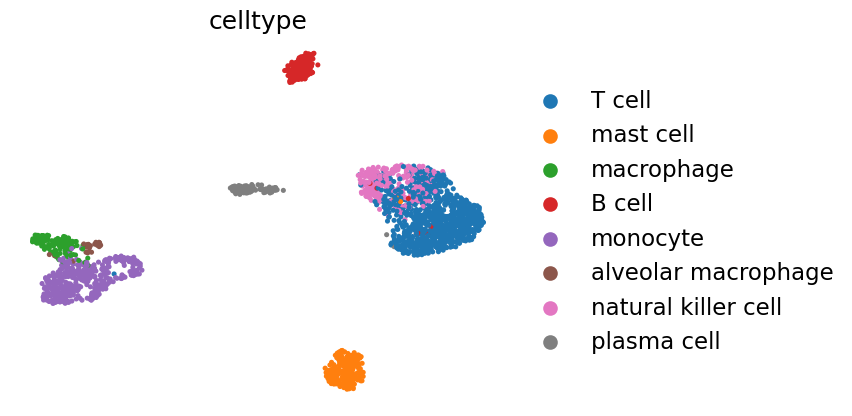

In [18]:
ref_embed_adata = scg.tasks.embed_data(
    s_data,
    model_dir,
    gene_col=gene_col,
    obs_to_save=cell_type_key,  # optional arg, only for saving metainfo
    batch_size=64,
    return_new_adata=True,
)

sc.pp.neighbors(ref_embed_adata, use_rep="X")
sc.tl.umap(ref_embed_adata)
sc.pl.umap(ref_embed_adata, color=cell_type_key, frameon=False, wspace=0.4)

In [28]:
test_embed_adata = scg.tasks.embed_data(
    t_data,
    model_dir,
    gene_col=gene_col,
    obs_to_save=cell_type_key,  # optional arg, only for saving metainfo
    batch_size=64,
    return_new_adata=True,
)

/home/hht/.conda/envs/scgpt/lib/python3.9/site-packages/scgpt/tasks/cell_emb.py:190: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var["index"] = adata.var.index
/home/hht/.conda/envs/scgpt/lib/python3.9/site-packages/torch/cuda/__init__.py:138: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 11060). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0


scGPT - INFO - match 1509/1781 genes in vocabulary of size 60697.


/home/hht/.local/lib/python3.9/site-packages/anndata/_core/anndata.py:1105: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/home/hht/.conda/envs/scgpt/lib/python3.9/site-packages/scgpt/model/model.py:77: UserWarning: flash-attn is not installed, using pytorch transformer instead. Set use_fast_transformer=False to avoid this warning. Installing flash-attn is highly recommended.
  warnings.warn(
/home/hht/.conda/envs/scgpt/lib/python3.9/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Embedding cells:   0%|          | 0/18 [00:00<?, ?it/s]/home/hht/.conda/envs/scgpt/lib/python3.9/site-packages/torch/nn/modules/transformer.py:380: UserWarning: The PyTorch API of nested tensors is in prototype stage and will change in the near future. (Triggered inte

In [38]:
# ref_cell_embeddings = ref_embed_adata.X
test_emebd = test_embed_adata.X

k = 10  # number of neighbors


# index = faiss.IndexFlatL2(ref_cell_embeddings.shape[1])
# index.add(ref_cell_embeddings)

# Query dataset, k - number of closest elements (returns 2 numpy arrays)
# distances, labels = index.search(test_emebd, k)

idx_list=[i for i in range(test_emebd.shape[0])]
preds = []
# for k in idx_list:
    # idx = labels[k]
   
    # pred = ref_embed_adata.obs[cell_type_key][idx].value_counts()
    # preds.append(pred.index[0])
gt = t_data.obs[cell_type_key].to_numpy()

# sklearn.metrics.accuracy_score(gt, preds)

In [ ]:
ref_cell_embeddings = ref_embed_adata.X
test_emebd = test_embed_adata.X

k = 10  # number of neighbors


index = faiss.IndexFlatL2(ref_cell_embeddings.shape[1])
index.add(ref_cell_embeddings)

# Query dataset, k - number of closest elements (returns 2 numpy arrays)
distances, labels = index.search(test_emebd, k)

idx_list=[i for i in range(test_emebd.shape[0])]
preds = []
for k in idx_list:
    idx = labels[k]
   
    pred = ref_embed_adata.obs[cell_type_key][idx].value_counts()
    preds.append(pred.index[0])
gt = t_data.obs[cell_type_key].to_numpy()

sklearn.metrics.accuracy_score(gt, preds)

In [37]:
np.concatenate([ref_cell_embeddings, test_emebd]).shape[1]

512

In [ ]:
pd.DataFrame(ref_cell_embeddings)

## step3

In [29]:
from build_atlas_index_faiss import load_index, vote

In [30]:
# use_gpu = faiss.get_num_cpus() > 0
index, meta_labels = load_index(
    index_dir="scgpt",
    use_config_file=False,
    use_gpu=False,
)
print(f"Loaded index with {index.ntotal} cells")


Loading index and meta from scgpt ...
Index loaded, num_embeddings: 35096827
Set nprobe from 128 to 128 for 16384 clusters
Loaded index with 35096827 cells


In [34]:
k = 50
# test with the first 100 cells
distances, idx = index.search(test_emebd, k)

In [35]:
predict_labels = meta_labels[idx]
# from scipy.stats import mode
from tqdm import tqdm

voting = []
for preds in tqdm(predict_labels):
    voting.append(vote(preds, return_prob=False)[0])
voting = np.array(voting)

100%|██████████| 1100/1100 [00:00<00:00, 20151.98it/s]


In [39]:
print(gt[:10])   # Original labels in the query dataset, used for evaluation
print(voting[:10])  # Propagated CellXGene labels

['monocyte' 'T cell' 'dendritic cell' 'monocyte' 'T cell' 'dendritic cell'
 'monocyte' 'dendritic cell' 'monocyte' 'natural killer cell']
['classical monocyte' 'CD4-positive, alpha-beta T cell' 'macrophage'
 'classical monocyte' 'natural killer cell' 'macrophage' 'macrophage'
 'conventional dendritic cell' 'classical monocyte'
 'CD16-positive, CD56-dim natural killer cell, human']
